## Lab 9: Digit Orientation Prediction with PyTorch
In this lab you will implement a version of image orientation detector in PyTorch. You will explore image directory based data loaders, building models using PyTorch pre-defined layers, implementing mini-batch learning using data loaders, and using input transformations for data augmentation.

### Question 1: Data Loading
The data for this lab are contained in raw image files instead of pre-loaded into a data array. They can be loaded using a PyTorch data loader. The data loader applies a transform to turn the raw images it loads into vectors. The data loader also takes care of shuffling and batching data. Below we show how to create a data loader of the training set. Add code to load the validation and test sets.   

In [60]:
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Grayscale(), #convert to grayscale
    transforms.ToTensor(), #convert to a tensor
    transforms.Lambda(torch.flatten) #flatten to vectors
])

batch_size    = 1024
train_dataset = ImageFolder(root='data/train', transform=transform)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=0, pin_memory=True)

test_dataset = ImageFolder(root='data/test', transform=transform)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=True,num_workers=0, pin_memory=True)

val_dataset = ImageFolder(root='data/val', transform=transform)
val_loader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=True,num_workers=0, pin_memory=True)

Once the data loader is defined, you can sample a batch of random data vectors and labels from it to verify the data loading and transformations are correct.

In [61]:
X, Y = next(iter(train_loader))
print(X.shape)
print(Y.shape)

torch.Size([250, 784])
torch.Size([250])


### Question 2: Data Visualization
Use matplotlib to visualize the first five training, validation and test vectors returned by each data loader. You will need to transform the images back into 28x28 images and then display them. Show a title for each image specifying the image's label as both a string and numerical value. The string labels for each class are contained in the dataset objects.

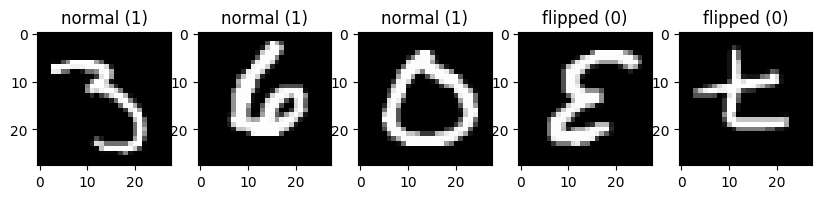

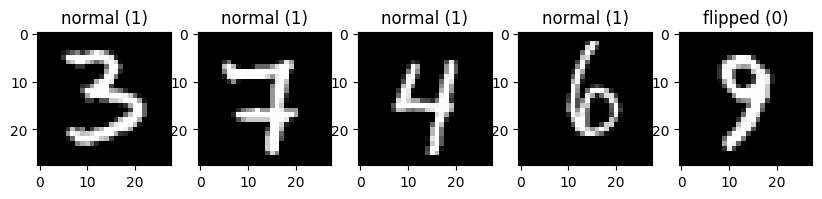

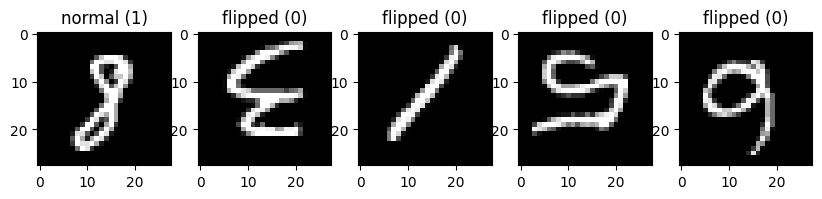

In [84]:
import matplotlib.pyplot as plt

X, Y = next(iter(train_loader))
plt.figure(figsize=(10,2))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(X[i,:].reshape([28,28]),cmap="gray")
    plt.title(f"{train_dataset.classes[Y[i]]} ({Y[i]})")

X, Y = next(iter(val_loader))
plt.figure(figsize=(10,2))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(X[i,:].reshape([28,28]),cmap="gray")
    plt.title(f"{val_dataset.classes[Y[i]]} ({Y[i]})")

X, Y = next(iter(test_loader))
plt.figure(figsize=(10,2))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(X[i,:].reshape([28,28]),cmap="gray")
    plt.title(f"{test_dataset.classes[Y[i]]} ({Y[i]})")


### Question 3: Model Construction
For a model, you will implement probabilistic logistic regression as a PyTorch neural network module. A basic module requires specifying just two methods. __init__() and forward(). 

The init method initializes the model object. For this model, we include a single argument D, the length of the input data vector. You should implement the model using PyTorch's existing linear layer type nn.Linear. See the PyTorch API documents for information on how to define and use this layer: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html.

The forward method method should compute the probability that an input vector belongs to class 1. This requires the application of the linear layer, followed by the sigmoid/logistic function. See the documentation for the sigmoid function here: https://pytorch.org/docs/stable/generated/torch.nn.functional.sigmoid.html. The implementation needs to be vectorized so it computes the required probability for each row of the input tensor X.

In [63]:
import torch.nn as nn
import torch.nn.functional as F

class plr(nn.Module):
    def __init__(self,D):
        super(plr, self).__init__()
        self.fc1 = nn.Linear(D, 1)

    def forward(self, X):
        a = self.fc1(X)
        p = F.sigmoid(a)
        return(p)

To verify that your implementation runs without error, try the following code. This code creates a model object, then runs the forward function to compute output class probabilities. The probabilities will be computed using the default randomly initialized model parameters used by the pre-defined fully connected layer. If the code fails to run, it has bugs and needs more work. 

In [64]:
X, Y  = next(iter(train_loader))
model = plr(784)
P     = model.forward(X)
P[:10]

tensor([[0.4827],
        [0.4354],
        [0.5220],
        [0.5263],
        [0.4840],
        [0.4681],
        [0.4026],
        [0.4890],
        [0.4935],
        [0.5069]], grad_fn=<SliceBackward0>)

### Question 4: Model Training
In this question you will complete the specification of code needed to optimize the model parameters. The only missing component in the implementation is the computation of the loss. You can either compute the negative log likelihood from scratch, or investigate the use of PyTorch's built in loss function binary_cross_entropy() documented here: https://pytorch.org/docs/stable/generated/torch.nn.functional.binary_cross_entropy.html. Once you have the loss implemented, execute the code to verify that the implementation runs and the loss and training error are decreasing.

In [81]:
from torch import optim

device = "cuda" if torch.cuda.is_available() else "cpu" #Set device to gpu or cpu

model      = plr(784) 
lr         = 0.001
num_epochs = 100
train_loss = []
train_err  = []

optimizer  = optim.Adam(model.parameters(), lr=lr,weight_decay=1e-1)

# Start loop
for epoch in range(num_epochs): #(loop for every epoch)

    model.train()    # training mode
    running_loss = 0.0   
    running_error = 0.0 

    for i, (X, Y) in enumerate(train_loader): # load a batch data of images

        #Move batch to device if needed
        X = X.to(device)
        Y = Y.to(device) 

        optimizer.zero_grad() #Zero the gradient
        P = model.forward(X)  #Compute predicted probabilities
        Yhat = P>0.5          #Compute predictions

        P=torch.clip(P,0.01,0.99).flatten() #Clip the probabilities to avoid log(0)

        loss = -1*torch.mean(Y*torch.log(P) + (1-Y)*torch.log(1-P)) #Compute the loss

        loss.backward()       #Compute the gradient of the loss
        optimizer.step()      #Take a step

        # update running loss and error
        running_loss  += loss.item() * X.shape[0]
        running_error += torch.sum(Yhat.flatten() != Y.flatten()).item()

    #Compute loss for the epoch
    epoch_loss  = running_loss /  len(train_loader.dataset)
    epoch_error = running_error / len(train_loader.dataset) 

    # Append result
    train_loss.append(epoch_loss)
    train_err.append(epoch_error)

    # Print progress
    print('[Train #{}] Loss: {:.8f} Err: {:.4f}'.format(epoch+1, epoch_loss, epoch_error))

[Train #1] Loss: 0.66824049 Err: 0.3960
[Train #2] Loss: 0.65905112 Err: 0.3600
[Train #3] Loss: 0.65005916 Err: 0.3280
[Train #4] Loss: 0.64126647 Err: 0.3040
[Train #5] Loss: 0.63267189 Err: 0.2760
[Train #6] Loss: 0.62427652 Err: 0.2520
[Train #7] Loss: 0.61608028 Err: 0.2440
[Train #8] Loss: 0.60808092 Err: 0.2320
[Train #9] Loss: 0.60027468 Err: 0.2200
[Train #10] Loss: 0.59265757 Err: 0.2040
[Train #11] Loss: 0.58522576 Err: 0.1880
[Train #12] Loss: 0.57797527 Err: 0.1880
[Train #13] Loss: 0.57090276 Err: 0.1760
[Train #14] Loss: 0.56400472 Err: 0.1720
[Train #15] Loss: 0.55727756 Err: 0.1680
[Train #16] Loss: 0.55071789 Err: 0.1640
[Train #17] Loss: 0.54432207 Err: 0.1560
[Train #18] Loss: 0.53808647 Err: 0.1560
[Train #19] Loss: 0.53200746 Err: 0.1520
[Train #20] Loss: 0.52608168 Err: 0.1400
[Train #21] Loss: 0.52030545 Err: 0.1360
[Train #22] Loss: 0.51467550 Err: 0.1280
[Train #23] Loss: 0.50918823 Err: 0.1240
[Train #24] Loss: 0.50384009 Err: 0.1280
[Train #25] Loss: 0.49862

### Question 5: Evaluation 
Now use the validation and test set data loaders to evaluate the prediction error rate of the learned model. Since both the data loaders use batching, you will need to loop over all of the batches to compute the test and validation error rates. Add your code below.

In [85]:
def eval(model, dataloader):

    running_loss = 0.0   
    running_error = 0.0 

    for i, (X, Y) in enumerate(dataloader): # load a batch data of images

        #Move batch to device if needed
        X = X.to(device)
        Y = Y.to(device) 

        P = model.forward(X)  #Compute predicted probabilities
        Yhat = P>0.5          #Compute predictions
        P=torch.clip(P,0.01,0.99).flatten() #Clip the probabilities to avoid log(0)

        loss = -1*torch.mean(Y*torch.log(P) + (1-Y)*torch.log(1-P)) #Compute the loss

        # update running loss and error
        running_loss  += loss.item() * X.shape[0]
        running_error += torch.sum(Yhat.flatten() != Y.flatten()).item()

    #Compute loss for the epoch
    loss  = running_loss /  len(dataloader.dataset)
    error = running_error / len(dataloader.dataset) 

    return(loss, error)

val_loss, val_err = eval(model, val_loader) 
test_loss, test_err = eval(model, test_loader) 

print(f"Val loss: {val_loss:0.4f}  Val errpr: {val_err:0.4f} ")
print(f"Test loss: {test_loss:0.4f}  Val errpr: {test_err:0.4f} ")

Val loss: 0.4070  Val errpr: 0.1300 
Test loss: 0.4079  Val errpr: 0.1290 


### Question 6: Data Augmentation
One way to make an image classification model more robust is to apply augmentations to the training data set during learning such as adding pixel noise, random rotations, random crops, image blur, etc. These data augmentations need to be selected such that you would expect the label of the instance to be preserved. Try experimenting with adding additional image transforms to the training data set loader. The transforms implemented in the TorchVision package are documented here: https://pytorch.org/vision/0.20/transforms.html. Such data augmentations are applied on the fly in the data loader each time a batch is returned. Make sure you *do not* add these augmentations to the validation and test data loaders. See if you can improve the generalization performance of the model using data augmentations. 